# 1. IMPORT DEPENDENCIES

In [4]:
import os
import wget

In [5]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [6]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'IMAGE_PATH1': os.path.join('Tensorflow', 'workspace','images','train'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [7]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
import object_detection

In [ ]:
!pip list

# 2. Load Model From Checkpoint

In [9]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [10]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 3. Detect from an Image

In [15]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [21]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'check2.jpg')

In [ ]:
!pip install opencv-contrib-python
!pip install opencv-python

# Detect from Image

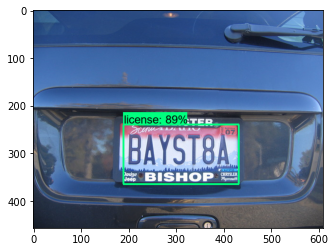

In [22]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
!pip uninstall opencv-python-headless -y

# 4.Detect License Plate from WebCam

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [ ]:
!pip install pytesseract

In [ ]:
pip install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

In [23]:
import easyocr
import pytesseract as tess
tess.pytesseract.tesseract_cmd = r'C:\Users\siddh\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
from PIL import Image
detection_threshold = 0.7

In [24]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [25]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5255496  0.31111717 0.7978149  0.7102406 ]
[240.1761629  189.47035789 364.60141188 432.53652692]
[([[203, 5], [239, 5], [239, 23], [203, 23]], '307', 0.5775611753886714), ([[1, 9], [237, 9], [237, 97], [1, 97]], 'BAYSTBA', 0.5323724824665848), ([[3, 99], [31, 99], [31, 111], [3, 111]], 'Jodgt', 0.1436382885765344), ([[203, 99], [243, 99], [243, 111], [203, 111]], 'CHRTSLR', 0.28722967437224073), ([[3, 109], [31, 109], [31, 123], [3, 123]], 'Joop', 0.6265845894813538), ([[44, 96], [194, 96], [194, 124], [44, 124]], 'BISHOP', 0.9382864911511535), ([[206, 110], [236, 110], [236, 118], [206, 118]], 'Kdwioui', 0.048629221118730935)]
---- BAYSTOA

 

2 BISHOP ==



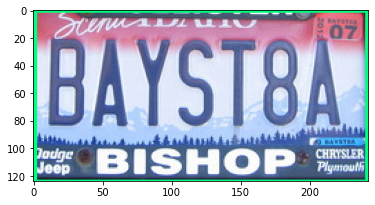

In [26]:
# Apply ROI filtering and OCR
c1=os.getcwd()
MATLAB_Path='C:/Users/siddh/Documents/MATLAB'
for idx, box in enumerate(boxes):
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

os.chdir(MATLAB_Path)
cv2.imwrite('crop_lic_plate2.jpg', region)
img=Image.open('crop_lic_plate2.jpg')
text=tess.image_to_string(img)
print("----",text)
os.chdir(c1)

In [27]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

18
307
88
BAYSTBA
12
Jodgt
12
CHRTSLR
14
Joop
28
BISHOP
8
Kdwioui


In [28]:
region_threshold = 0.05
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [29]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


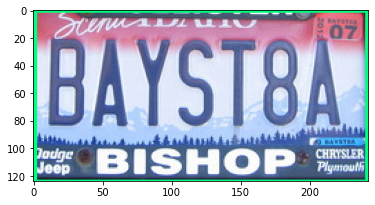

['BAYSTBA', 'BISHOP']


In [30]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

# 13. Zip and Export Models 

In [ ]:
!{command}